In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import json
import glob
import os
import re

from shared import *

In [2]:
base = "../exp/"
paths = glob.glob(base + "data/*.json")
data = [json.load(open(path)) for path in paths]

In [3]:
queries = pd.DataFrame.from_records([{
    **algo,
    'graph': path_to_graph(run['args'][1]),
    'metric': run['live_weight_file'],
    'queries': run['queries'],
    'epsilon': run['epsilon'],
} for run in data for algo in run['algo_runs']])

In [4]:
queries['instance'] = queries['graph'].map({'OSM Europe': 'OSM Eur ', 'DIMACS Europe': 'DIMACS Eur ', 'OSM Germany': 'OSM Ger '}) + queries['metric'].map({'fake_traffic': 'Syn', 'heavy_traffic': 'Fri', 'lite_traffic': 'Tue'})
queries['queries'] = queries['queries'].map({ 'queries/1h': '1h', 'queries/4h': '4h', 'queries/uniform': 'Random' })
queries['algo'] = queries['algo'].map({ 'iterative_detour_blocking': 'IDB', 'iterative_path_blocking': 'IPB', 'iterative_path_fixing': 'IPF' })

In [5]:
instance_order = ['DIMACS Eur Syn', 'OSM Eur Syn', 'OSM Ger Fri', 'OSM Ger Tue']
query_order = ['1h', '4h', 'Random']
algo_order = ['IPB', 'IDB', 'IPF']

In [6]:
queries_sub = queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2")
table = queries_sub.query('~failed').groupby(['queries', 'instance', 'algo']).median()[['length_increase_percent']].join( \
    queries_sub.groupby(['queries', 'instance', 'algo']) \
    .median()[['running_time_ms', 'failed']]) \
    .unstack()

table['failed'] *= 100
table = table.round(1)
# for col in ['running_time_ms', 'num_forbidden_paths']:
#     table[col] = table[col].round(1)
# for col in ['length_increase_percent', 'num_iterations']:
#     table[col] = table[col].round(2)
# table = table.rename(columns={ 'iterative_detour_blocking': 'IDB', 'iterative_path_blocking': 'IPB', 'iterative_path_fixing': 'IPF' })
table = table.reindex(columns=algo_order, level=1)

# table = table.swaplevel(axis='columns').sort_index(axis='columns').reindex(columns=['length_increase_percent', 'num_iterations', 'num_forbidden_paths', 'running_time_ms', 'failed'], level=1)

output = table.to_latex()
output = output.replace('1h', R"\multirow{4}{*}{\rotatebox[origin=c]{90}{1h}}")
output = output.replace('4h', R"\addlinespace \multirow{4}{*}{\rotatebox[origin=c]{90}{4h}}")
output = output.replace('Random', R"\addlinespace \multirow{4}{*}{\rotatebox[origin=c]{90}{Random}}")
lines = output.split("\n")
lines = [R'\setlength{\tabcolsep}{4pt}'] + lines[:2] + [
    R" & & \multicolumn{3}{c}{Increase $[\%]$} & \multicolumn{3}{c}{Time [ms]} & \multicolumn{3}{c}{Failed $[\%]$} \\",
    R"\cmidrule(l{3pt}r{3pt}){3-5} \cmidrule(l{3pt}r{3pt}){6-8} \cmidrule(l{3pt}r{3pt}){9-11}",
    R" & & IPB & IDB & IPF & IPB & IDB & IPF & IPB & IDB & IPF \\"
] + lines[5:]
output = add_latex_big_number_spaces("\n".join(lines) + "\n")

print(output)
table

\setlength{\tabcolsep}{4pt}
\begin{tabular}{llrrrrrrrrr}
\toprule
 & & \multicolumn{3}{c}{Increase $[\%]$} & \multicolumn{3}{c}{Time [ms]} & \multicolumn{3}{c}{Failed $[\%]$} \\
\cmidrule(l{3pt}r{3pt}){3-5} \cmidrule(l{3pt}r{3pt}){6-8} \cmidrule(l{3pt}r{3pt}){9-11}
 & & IPB & IDB & IPF & IPB & IDB & IPF & IPB & IDB & IPF \\
\midrule
\multirow{4}{*}{\rotatebox[origin=c]{90}{1h}} & DIMACS Eur Syn &                     0.0 &  0.0 &  0.0 &             0.9 &    0.7 &   0.7 &    0.0 &  0.0 &  0.0 \\
       & OSM Eur Syn &                     0.0 &  0.0 &  0.0 &             1.6 &    1.0 &   1.2 &    0.0 &  0.0 &  0.0 \\
       & OSM Ger Fri &                     0.0 &  0.0 &  0.0 &             1.8 &    0.9 &   0.9 &    0.0 &  0.0 &  0.0 \\
       & OSM Ger Tue &                     0.0 &  0.0 &  0.0 &             1.1 &    0.7 &   0.9 &    0.0 &  0.0 &  0.0 \\
\addlinespace \multirow{4}{*}{\rotatebox[origin=c]{90}{4h}} & DIMACS Eur Syn &                     0.1 &  1.0 &  1.6 &            39.0 

length_increase_percent           running_time_ms  \
algo                                       IPB  IDB  IPF             IPB   
queries instance                                                           
1h      DIMACS Eur Syn                     0.0  0.0  0.0             0.9   
        OSM Eur Syn                        0.0  0.0  0.0             1.6   
        OSM Ger Fri                        0.0  0.0  0.0             1.8   
        OSM Ger Tue                        0.0  0.0  0.0             1.1   
4h      DIMACS Eur Syn                     0.1  1.0  1.6            39.0   
        OSM Eur Syn                        0.0  0.0  0.0             9.3   
        OSM Ger Fri                        0.0  1.4  2.7         10003.7   
        OSM Ger Tue                        0.0  0.0  0.0             6.7   
Random  DIMACS Eur Syn                     0.5  2.1  3.3         10006.9   
        OSM Eur Syn                        0.1  0.2  0.3          2804.7   
        OSM Ger Fri                        0.0  0.8  2.1         10002.6   
        OSM Ger Tue                        0.0  0.0  0.0             5.5   

                                    failed            
algo                      IDB   IPF    IPB  IDB  IPF  
queries instance                                      
1h      DIMACS Eur Syn    0.7   0.7    0.0  0.0  0.0  
        OSM Eur Syn       1.0   1.2    0.0  0.0  0.0  
        OSM Ger Fri       0.9   0.9    0.0  0.0  0.0  
        OSM Ger Tue       0.7   0.9    0.0  0.0  0.0  
4h      DIMACS Eur Syn    7.5   3.9    0.0  0.0  0.0  
        OSM Eur Syn       4.8   5.1    0.0  0.0  0.0  
        OSM Ger Fri     397.2  48.2  100.0  0.0  0.0  
        OSM Ger Tue       4.9   4.7    0.0  0.0  0.0  
Random  DIMACS Eur Syn  229.1  17.9  100.0  0.0  0.0  
        OSM Eur Syn     101.1  62.9    0.0  0.0  0.0  
        OSM Ger Fri     185.4  31.1  100.0  0.0  0.0  
        OSM Ger Tue       4.1   4.0    0.0  0.0  0.0

In [7]:
per_query_grouper = ['queries', 'instance', 'epsilon', 'from', 'to']
best_values = queries.query('~failed').groupby(per_query_grouper)[['running_time_ms', 'length_increase_percent']].min()

In [8]:
queries = queries.join(best_values, on=per_query_grouper, rsuffix='_min')

In [9]:
queries['time_perf'] = queries.query('~failed')['running_time_ms'] / queries.query('~failed')['running_time_ms_min'] 
queries['len_perf'] = (queries.query('~failed')['length_increase_percent'] + 100) / (queries.query('~failed')['length_increase_percent_min'] + 100)
queries['time_perf'] = queries['time_perf'].fillna(np.inf)
queries['len_perf'] = queries['len_perf'].fillna(np.inf)

/tmp/ipykernel_45709/560854255.py:2: RuntimeWarning: invalid value encountered in subtract
  sub['time_ratio'] = sub.groupby('algo')['time_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
/tmp/ipykernel_45709/560854255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['time_ratio'] = sub.groupby('algo')['time_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())


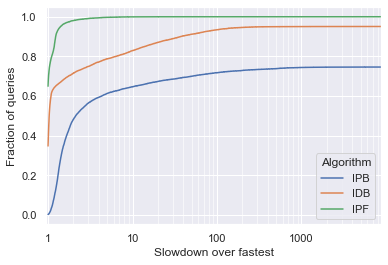

In [10]:
sub = queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2")
sub['time_ratio'] = sub.groupby('algo')['time_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
g = sns.lineplot(data=sub, x='time_perf', y='time_ratio', hue='algo', hue_order=algo_order, drawstyle='steps-post')
g.set(xscale="log")
g.set_xlabel('Slowdown over fastest')
g.set_ylabel('Fraction of queries')
g.xaxis.set_major_formatter(mpl.ticker.LogFormatter())
plt.grid(True, which="minor", linewidth=0.6)
g.legend(title='Algorithm')
max_x = g.get_xlim()[1]
g.set_xlim(0.95, max_x)
for line in g.get_lines()[:3]:
    (x, y) = line.get_data()
    line.set_data(np.append(x, [max_x]), np.append(y, [y[-1]]))

/tmp/ipykernel_45709/3439294675.py:1: RuntimeWarning: invalid value encountered in subtract
  queries['time_ratio'] = queries.groupby(['algo', 'instance', 'queries', 'epsilon'])['time_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())


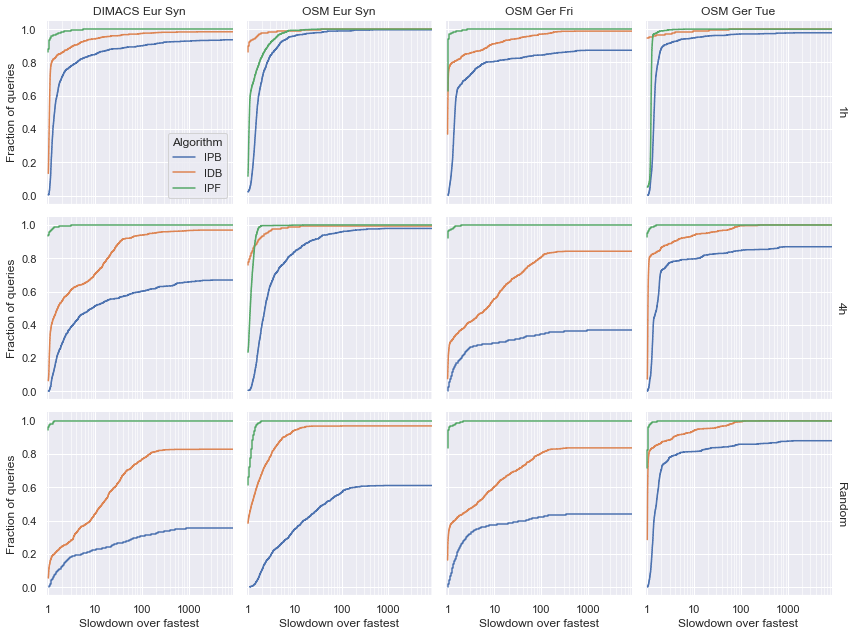

In [11]:
queries['time_ratio'] = queries.groupby(['algo', 'instance', 'queries', 'epsilon'])['time_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
g = sns.FacetGrid(queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2"), margin_titles=True, legend_out=False,
                  row='queries', col='instance', hue='algo', row_order=query_order, col_order=instance_order, hue_order=algo_order)
g.map_dataframe(sns.lineplot, x='time_perf', y='time_ratio', drawstyle='steps-post')
g.set(xscale="log")
g.set_xlabels('Slowdown over fastest')
g.set_ylabels('Fraction of queries')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Algorithm')
for axs in g.axes:
    for ax in axs:
        ax.xaxis.set_major_formatter(mpl.ticker.LogFormatter())
        ax.grid(True, which="minor", linewidth=0.6)
        max_x = ax.get_xlim()[1]
        ax.set_xlim(0.9, max_x)
        lines = ax.get_lines()
        for line in lines:
            (x, y) = line.get_data()
            line.set_data(np.append(x, [max_x]), np.append(y, [y[-1]]))

/tmp/ipykernel_45709/3153486802.py:4: RuntimeWarning: invalid value encountered in subtract
  sub['time_ratio'] = sub.groupby('algo')['running_time_ms_success'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
/tmp/ipykernel_45709/3153486802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['time_ratio'] = sub.groupby('algo')['running_time_ms_success'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())


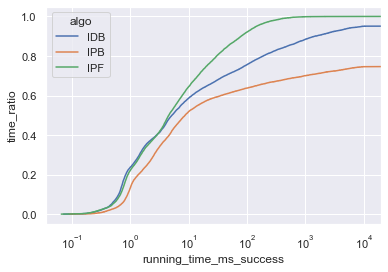

In [14]:
queries['running_time_ms_success'] = queries.query('~failed')['running_time_ms']
queries['running_time_ms_success'] = queries['running_time_ms_success'].fillna(np.inf)
sub = queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2")
sub['time_ratio'] = sub.groupby('algo')['running_time_ms_success'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
g = sns.lineplot(data=sub, x='running_time_ms_success', y='time_ratio', hue='algo', drawstyle='steps-post')
g.set(xscale="log")
max_x = g.get_xlim()[1]
for line in g.get_lines()[:3]:
    (x, y) = line.get_data()
    line.set_data(np.append(x, [max_x]), np.append(y, [y[-1]]))

/tmp/ipykernel_45709/590653360.py:1: RuntimeWarning: invalid value encountered in subtract
  queries['time_ratio'] = queries.groupby(['algo', 'instance', 'queries', 'epsilon'])['running_time_ms_success'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())


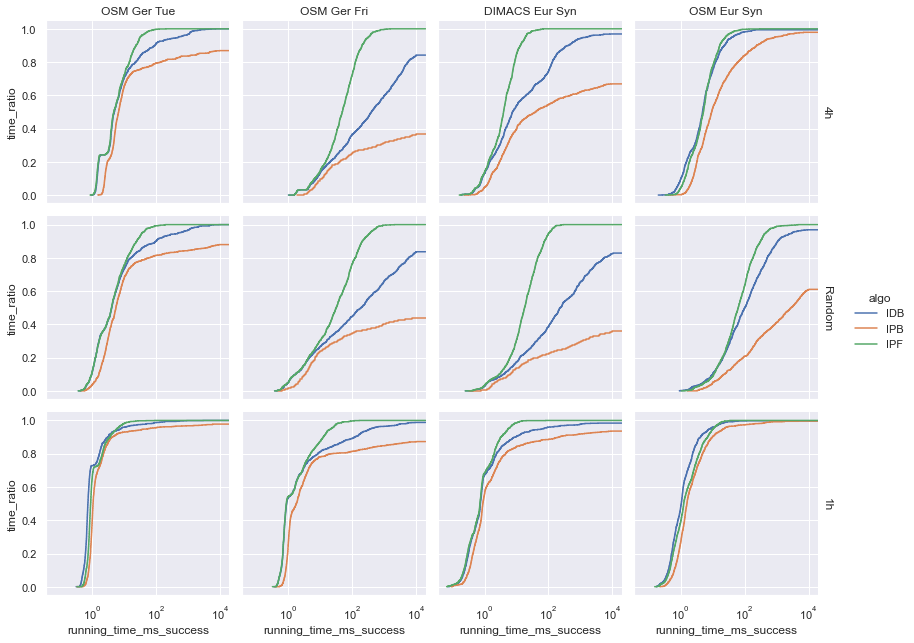

In [15]:
queries['time_ratio'] = queries.groupby(['algo', 'instance', 'queries', 'epsilon'])['running_time_ms_success'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
g = sns.FacetGrid(queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2"), row='queries', col='instance', hue='algo', margin_titles=True)
g.map_dataframe(sns.lineplot, x='running_time_ms_success', y='time_ratio', drawstyle='steps-post')
g.set(xscale="log")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()
for axs in g.axes:
    for ax in axs:
        max_x = ax.get_xlim()[1]
        lines = ax.get_lines()
        for line in lines:
            (x, y) = line.get_data()
            line.set_data(np.append(x, [max_x]), np.append(y, [y[-1]]))

/tmp/ipykernel_45709/878509762.py:2: RuntimeWarning: invalid value encountered in subtract
  sub['len_ratio'] = sub.groupby('algo')['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
/tmp/ipykernel_45709/878509762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['len_ratio'] = sub.groupby('algo')['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())


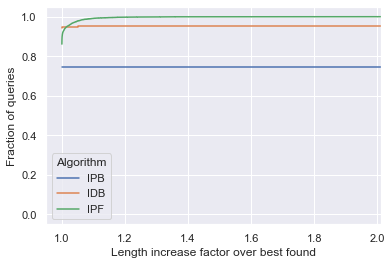

In [16]:
sub = queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2")
sub['len_ratio'] = sub.groupby('algo')['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
g = sns.lineplot(data=sub, x='len_perf', y='len_ratio', hue='algo', hue_order=algo_order, drawstyle='steps-post')
g.set_xlabel('Length increase factor over best found')
g.set_ylabel('Fraction of queries')
g.legend(title='Algorithm')
max_x = g.get_xlim()[1]
g.set_xlim(0.95, max_x)
g.set_ylim(-0.05, 1.05)
for line in g.get_lines()[:3]:
    (x, y) = line.get_data()
    line.set_data(np.append(x, [max_x]), np.append(y, [y[-1]]))

/tmp/ipykernel_45709/2082948348.py:1: RuntimeWarning: invalid value encountered in subtract
  queries['len_ratio'] = queries.groupby(['algo', 'instance', 'queries', 'epsilon'])['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())


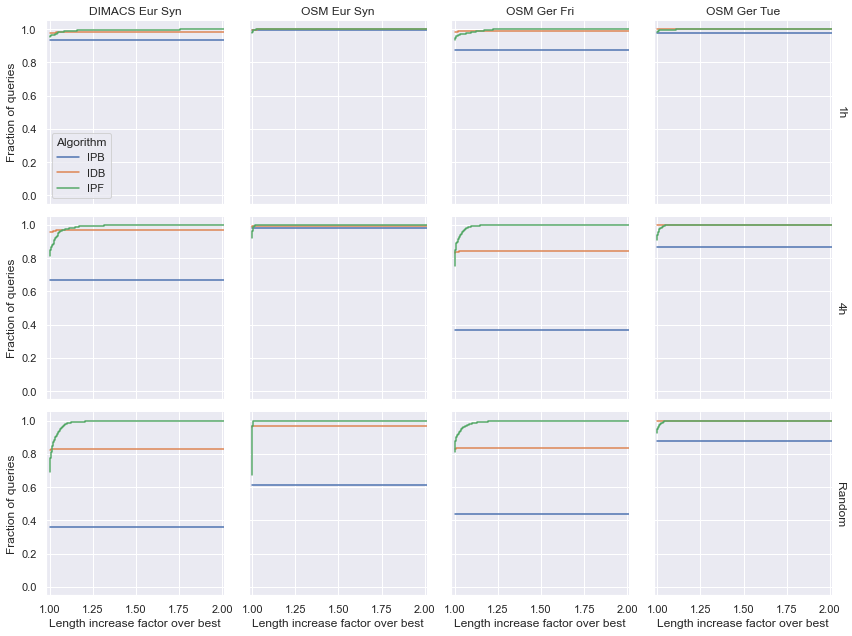

In [17]:
queries['len_ratio'] = queries.groupby(['algo', 'instance', 'queries', 'epsilon'])['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
g = sns.FacetGrid(queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2"), margin_titles=True, ylim=(-0.05,1.05), legend_out=False,
                 row='queries', col='instance', hue='algo', row_order=query_order, col_order=instance_order, hue_order=algo_order)
g.map_dataframe(sns.lineplot, x='len_perf', y='len_ratio', drawstyle='steps-post')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xlabels('Length increase factor over best')
g.set_ylabels('Fraction of queries')
g.add_legend(title='Algorithm')
for axs in g.axes:
    for ax in axs:
        max_x = ax.get_xlim()[1]
        ax.set_xlim(0.98, max_x)
        lines = ax.get_lines()
        for line in lines:
            (x, y) = line.get_data()
            line.set_data(np.append(x, [max_x]), np.append(y, [y[-1]]))

/tmp/ipykernel_45709/545691962.py:2: RuntimeWarning: invalid value encountered in subtract
  sub['len_ratio'] = sub.groupby('algo')['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
/tmp/ipykernel_45709/545691962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['len_ratio'] = sub.groupby('algo')['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
/tmp/ipykernel_45709/545691962.py:3: RuntimeWarning: invalid value encountered in subtract
  sub['time_ratio'] = sub.groupby('algo')['time_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
/tmp/ipykernel_45

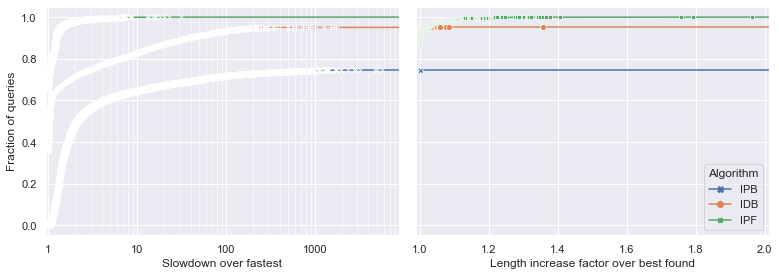

In [31]:
sub = queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2")
sub['len_ratio'] = sub.groupby('algo')['len_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())
sub['time_ratio'] = sub.groupby('algo')['time_perf'].transform(lambda group: np.sum(np.subtract.outer(group.values,group.values)>=0, axis=1) / group.count())

fig, axs = plt.subplots(1, 2, figsize=(11,4), sharey=True)

g = sns.lineplot(data=sub, x='time_perf', y='time_ratio', hue='algo', style='algo', hue_order=algo_order, drawstyle='steps-post', markers=['+', 'x', 'x'], dashes=False, ax=axs[0], legend=False)
g.set(xscale="log")
g.set_xlabel('Slowdown over fastest')
g.set_ylabel('Fraction of queries')
g.xaxis.set_major_formatter(mpl.ticker.LogFormatter())
g.grid(True, which="minor", linewidth=0.6)
max_x = g.get_xlim()[1]
g.set_xlim(0.95, max_x)
for line in g.get_lines()[:3]:
    (x, y) = line.get_data()
    line.set_data(np.append(x, [max_x + 10000]), np.append(y, [y[-1]]))
    
g = sns.lineplot(data=sub, x='len_perf', y='len_ratio', hue='algo', style='algo', hue_order=algo_order, drawstyle='steps-post', markers=True, dashes=False, ax=axs[1])
g.set_xlabel('Length increase factor over best found')
g.set_ylabel('Fraction of queries')
g.legend(title='Algorithm', loc='lower right')
max_x = g.get_xlim()[1]
g.set_xlim(0.99, max_x)
#g.set_ylim(-0.05, 1.05)
for line in g.get_lines()[:3]:
    (x, y) = line.get_data()
    line.set_data(np.append(x, [max_x + 1]), np.append(y, [y[-1]]))
    
plt.tight_layout()

In [23]:
sub.query('~failed').groupby('algo').describe()[['time_perf', 'len_perf']]

time_perf                                                            \
         count       mean         std  min       25%       50%       75%   
algo                                                                       
IDB    11410.0   8.847603   43.055364  1.0  1.000000  1.026729  1.964660   
IPB     8955.0  22.281097  147.322191  1.0  1.300043  1.580953  2.898983   
IPF    12000.0   1.113171    0.633175  1.0  1.000000  1.000000  1.044735   

                  len_perf                                                    
              max    count      mean       std  min  25%  50%  75%       max  
algo                                                                          
IDB   1705.621827  11410.0  1.000131  0.003891  1.0  1.0  1.0  1.0  1.357979  
IPB   5654.080772   8955.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.000000  
IPF     31.377672  12000.0  1.003768  0.023879  1.0  1.0  1.0  1.0  1.963819

In [18]:
queries['instance_q'] = queries['instance'] + '\n' + queries['queries']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'OSM Ger Tue\nqueries/4h'),
  Text(1, 0, 'OSM Ger Fri\nqueries/4h'),
  Text(2, 0, 'OSM Ger Tue\nqueries/uniform'),
  Text(3, 0, 'DIMACS Eur Syn\nqueries/4h'),
  Text(4, 0, 'DIMACS Eur Syn\nqueries/uniform'),
  Text(5, 0, 'OSM Eur Syn\nqueries/1h'),
  Text(6, 0, 'OSM Eur Syn\nqueries/4h'),
  Text(7, 0, 'OSM Ger Tue\nqueries/1h'),
  Text(8, 0, 'OSM Eur Syn\nqueries/uniform'),
  Text(9, 0, 'DIMACS Eur Syn\nqueries/1h'),
  Text(10, 0, 'OSM Ger Fri\nqueries/uniform'),
  Text(11, 0, 'OSM Ger Fri\nqueries/1h')])

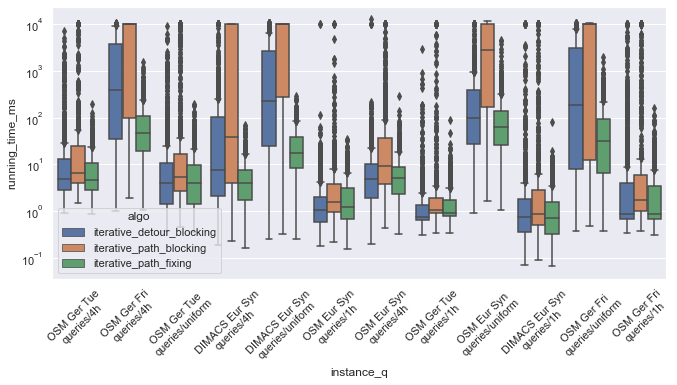

In [19]:
plt.figure(figsize=(11,5))
g = sns.boxplot(data=queries.query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2"), x='instance_q', y='running_time_ms', hue='algo')
g.set_yscale('log')
plt.xticks(rotation=45)

In [68]:
all_algos_succeeded_mask = queries.groupby(per_query_grouper)['failed'].transform(lambda group: (~group).all())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'OSM Ger Tue\nqueries/4h'),
  Text(1, 0, 'OSM Ger Fri\nqueries/4h'),
  Text(2, 0, 'OSM Ger Tue\nqueries/uniform'),
  Text(3, 0, 'DIMACS Eur Syn\nqueries/4h'),
  Text(4, 0, 'DIMACS Eur Syn\nqueries/uniform'),
  Text(5, 0, 'OSM Eur Syn\nqueries/1h'),
  Text(6, 0, 'OSM Eur Syn\nqueries/4h'),
  Text(7, 0, 'OSM Ger Tue\nqueries/1h'),
  Text(8, 0, 'OSM Eur Syn\nqueries/uniform'),
  Text(9, 0, 'DIMACS Eur Syn\nqueries/1h'),
  Text(10, 0, 'OSM Ger Fri\nqueries/uniform'),
  Text(11, 0, 'OSM Ger Fri\nqueries/1h')])

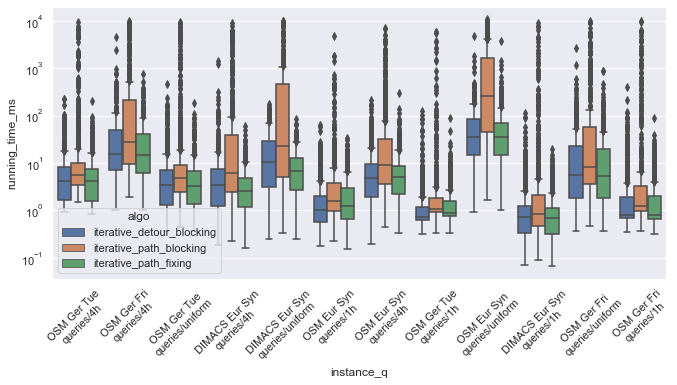

In [21]:
plt.figure(figsize=(11,5))
g = sns.boxplot(data=queries.loc[all_algos_succeeded_mask].query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2"), x='instance_q', y='running_time_ms', hue='algo')
g.set_yscale('log')
plt.xticks(rotation=45)

In [73]:
queries.loc[all_algos_succeeded_mask].query("~(graph == 'OSM Germany' & metric == 'fake_traffic') & epsilon == 0.2") \
    .groupby(['queries', 'instance', 'algo']).mean()[['length_increase_percent', 'running_time_ms']] \
    .unstack() \
    .round(2) \
    .reindex(columns=algo_order, level=1)

length_increase_percent             running_time_ms  \
algo                                       IPB   IDB   IPF             IPB   
queries instance                                                             
1h      DIMACS Eur Syn                    0.76  0.79  1.33           82.43   
        OSM Eur Syn                       0.22  0.22  0.24           19.84   
        OSM Ger Fri                       0.20  0.21  0.57          116.72   
        OSM Ger Tue                       0.07  0.07  0.14           42.19   
4h      DIMACS Eur Syn                    0.79  0.87  1.39          278.79   
        OSM Eur Syn                       0.24  0.24  0.27          124.28   
        OSM Ger Fri                       0.21  0.25  0.49          636.52   
        OSM Ger Tue                       0.05  0.05  0.12          158.07   
Random  DIMACS Eur Syn                    0.83  0.83  1.54          715.91   
        OSM Eur Syn                       0.19  0.19  0.21         1367.17   
        OSM Ger Fri                       0.18  0.20  0.49          345.74   
        OSM Ger Tue                       0.06  0.06  0.12          187.05   

                                      
algo                      IDB    IPF  
queries instance                      
1h      DIMACS Eur Syn   2.07   1.15  
        OSM Eur Syn      2.14   2.69  
        OSM Ger Fri      4.27   2.31  
        OSM Ger Tue      2.01   1.68  
4h      DIMACS Eur Syn  13.79   4.19  
        OSM Eur Syn      9.04   8.22  
        OSM Ger Fri     73.65  41.71  
        OSM Ger Tue      9.45   7.24  
Random  DIMACS Eur Syn  23.20   9.88  
        OSM Eur Syn     81.06  68.63  
        OSM Ger Fri     34.92  25.51  
        OSM Ger Tue      8.96   6.56